In [1]:
!nvidia-smi

Tue Jan 10 17:44:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   53C    P0   244W / 300W |  14725MiB / 32510MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   

In [2]:
import os
os.getcwd()

'/home/centos/psw/KSRC'

In [3]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer
from tokenizers import Tokenizer
from transformers import PreTrainedTokenizerFast, BartModel

In [4]:
# dpath = '/content/drive/My Drive/Seculayer/KSRC/'
train = pd.read_csv('data/with_kakao_train.csv',encoding='utf-8')
train = train.rename(columns={'Unnamed: 0':"index"})
test = pd.read_csv('data/test_data.csv',encoding='utf-8')
train.tail()

,index,premise,hypothesis,label
159470,159470,같은 방향으로 보이는 숲이 우거진 지역에 의상을 입은 사람들이 모여 있다.,사람들은 의상을 입는다,entailment
159471,159471,검은 원피스에 커다란 흰 활을 든 소녀가 카메라를 등지고 서 있다.,하이힐을 신은 남자,contradiction
159472,159472,검은 원피스에 커다란 흰 활을 든 소녀가 카메라를 등지고 서 있다.,서 있는 소녀,entailment
159473,159473,검은 원피스에 커다란 흰 활을 든 소녀가 카메라를 등지고 서 있다.,사진 촬영 준비를 하고 있는 소녀,neutral
159474,159474,한 남자가 유람선을 배경으로 부두에서 포즈를 취하고 있다.,포즈를 취하는 인간.,entailment


In [5]:
# 불 용어 처리 

train['premise'] = train['premise'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['premise'] = test['premise'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,index,premise,hypothesis,label
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다.,contradiction
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [6]:
train['hypothesis'] = train['hypothesis'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['hypothesis'] = test['hypothesis'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,index,premise,hypothesis,label
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다,contradiction
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다,neutral
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다,neutral


In [7]:
train['length'] = train['premise'].apply(lambda x: len(x))
train = train.loc[train['length']<105]
train.drop('length',axis=1,inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159325 entries, 0 to 159474
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   index       159325 non-null  int64 
 1   premise     159325 non-null  object
 2   hypothesis  159325 non-null  object
 3   label       159325 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.1+ MB


In [8]:
# 결측치는 없음

print(train.info(), end='\n\n')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159475 entries, 0 to 159474
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   index       159475 non-null  int64 
 1   premise     159475 non-null  object
 2   hypothesis  159475 non-null  object
 3   label       159475 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.9+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       1666 non-null   int64 
 1   premise     1666 non-null   object
 2   hypothesis  1666 non-null   object
 3   label       1666 non-null   object
dtypes: int64(1), object(3)
memory usage: 52.2+ KB
None


In [9]:
print('Train Label: ', train['label'].value_counts(), sep='\n', end='\n\n')

Train Label: 
entailment       53618
contradiction    53468
neutral          52389
Name: label, dtype: int64



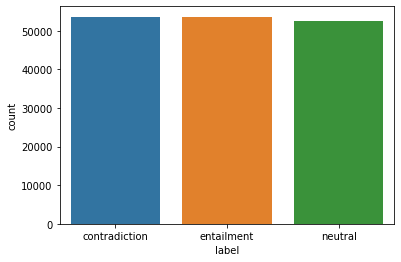

In [9]:
# data imbalance는 사실상 존재하지 않음 

sns.countplot(data=train,x='label');

In [29]:
max_premise = np.max(train['premise'].str.len())
max_hypothesis = np.max(train['hypothesis'].str.len())

In [30]:
print('max premise =',max_premise,"\nmax hypothesis =",max_hypothesis)

max premise = 104 
max hypothesis = 102


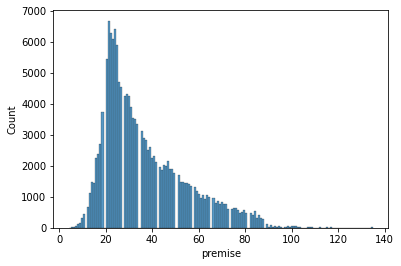

In [11]:
sns.histplot(x=train['premise'].str.len());

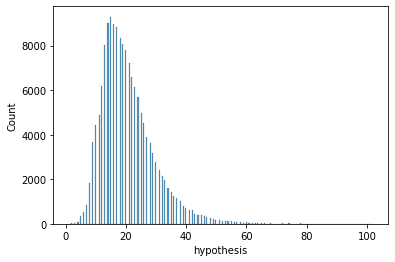

In [12]:
sns.histplot(x=train['hypothesis'].str.len());

In [8]:
def seed_everything(seed:int = 2023):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
MODEL_NAME = 'klue/roberta-large'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 3
# config.learning_rate = 2.5e-05
# config.warmup_ratio = 0.09
# config.weight_decay = 0.007

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

print(model)
print(config)

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifi

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [10]:
# train test split 및 tokenizing 
# token에 들어가는 문장은 premise와 hypothesis를 concat 한 문장

train_dataset, eval_dataset = train_test_split(train, test_size=0.2, shuffle=True, stratify=train['label'])

tokenized_train = tokenizer(
    list(train_dataset['premise']),
    list(train_dataset['hypothesis']),
    return_tensors="pt",
    max_length=210, # Max_Length = 190
    padding=True,
    truncation=True,
    add_special_tokens=True
)

tokenized_eval = tokenizer(
    list(eval_dataset['premise']),
    list(eval_dataset['hypothesis']),
    return_tensors="pt",
    max_length=210,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

print(tokenized_train['input_ids'][0])
print(tokenizer.decode(tokenized_train['input_ids'][0]))

tensor([    0,  6120,  2031,  2170,  2318,  9325,  2250,  2270,  2052,  2241,
         4819,  1325,  3677,  2470, 12447,  2170,  3979,  2069,  5072,  2259,
         1767,  2170,  3641,  2069, 10822,  2259, 27567,  1415,  2259,  4175,
        15351, 10031,  2069,  3681,  2200,  3855,  2052,  5837,  2205,  2062,
            2,  6120,  2031,  2073,  9325,  2250,  2270,  2069,  1889,  2015,
         2090,  2097,  5873,  3855,  2069,  3605,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])
[CLS] 대학생들에게 수강신청이란 취업 시 필요한 학점에 영향을 미치는 탓에 시간을 다투는 총성 없는 전쟁이나 다름없을 정도로 경쟁이 치열하다 [SEP] 대학생들은 수강신청을 하기위해 엄청난 경쟁을 한다 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [11]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, pair_dataset, label):
        self.pair_dataset = pair_dataset
        self.label = label

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item['label'] = torch.tensor(self.label[idx])
        
        return item

    def __len__(self):
        return len(self.label)
    
def label_to_num(label):
    label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2, "answer": 3}
    num_label = []

    for v in label:
        num_label.append(label_dict[v])

    return num_label


train_label = label_to_num(train_dataset['label'].values)
eval_label = label_to_num(eval_dataset['label'].values)

In [12]:
train_dataset = BERTDataset(tokenized_train, train_label)
eval_dataset = BERTDataset(tokenized_eval, eval_label)

# print(train_dataset.__len__())
# print(train_dataset.__getitem__(19997))
# print(tokenizer.decode(train_dataset.__getitem__(19997)['input_ids']))

In [13]:
def compute_metrics(pred):
  """ validation을 위한 metrics function """
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  probs = pred.predictions

  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds) # 리더보드 평가에는 포함되지 않습니다.

  return {
      'accuracy': acc,
  }

In [14]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, 
                                                              config=config)

def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 3e-5, 0.00004, log=True),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0, 0.6),
        "weight_decay": trial.suggest_float("weight_decay", 0, 0.01),
#         "num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
#         "seed": trial.suggest_int("seed", 20, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32]),
    }

# def my_hp_space(trial):
#     return {
#         "learning_rate":  trial.suggest_categorical("learning_rate", [0.00001,0.00002, 0.00003,0.00004,0.00005]),
#         "warmup_ratio":  trial.suggest_categorical("warmup_ratio", [0,0.1, 0.2,0.6]),
#         "weight_decay":  trial.suggest_categorical("weight_decay", [0, 0.01]),
# #         "num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
# #         "seed": trial.suggest_int("seed", 20, 40),
#         "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8,16, 32]),
#     }

In [19]:
import optuna

In [18]:
from transformers import EarlyStoppingCallback, IntervalStrategy

training_ars = TrainingArguments(
    output_dir='result/Large_data_roberta_hyperparameter_tune/',
    num_train_epochs=7,
    save_total_limit=5,
    save_steps=800,
    evaluation_strategy='steps',
    eval_steps = 800,
    load_best_model_at_end = True
)

trainer = Trainer(
    model_init=model_init,
    args=training_ars,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)])


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading weights file pytorch_model.bin from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/pytorch_model.bin
Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a 

In [20]:
trainer.hyperparameter_search(direction='maximize',
                             backend='optuna',
                             n_trials=10,
                             hp_space=my_hp_space)

[I 2023-01-10 17:51:14,594] A new study created in memory with name: no-name-c8bfaf27-2359-4955-acd7-d5fa22ea63b5
Trial: {'learning_rate': 3.734045079463956e-05, 'warmup_ratio': 0.10348143988560894, 'weight_decay': 0.00850552720218451, 'per_device_train_batch_size': 16}
loading weights file pytorch_model.bin from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/pytorch_model.bin
Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
800,0.866400,0.496066,0.820901
1600,0.490600,0.462724,0.826267
2400,0.495400,0.436528,0.833924
3200,0.496200,0.445254,0.828684
4000,0.460900,0.493826,0.847325
4800,0.389600,0.479550,0.839510


***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta_hyperparameter_tune/run-0/checkpoint-800
Configuration saved in result/Large_data_roberta_hyperparameter_tune/run-0/checkpoint-800/config.json
Model weights saved in result/Large_data_roberta_hyperparameter_tune/run-0/checkpoint-800/pytorch_model.bin
tokenizer config file saved in result/Large_data_roberta_hyperparameter_tune/run-0/checkpoint-800/tokenizer_config.json
Special tokens file saved in result/Large_data_roberta_hyperparameter_tune/run-0/checkpoint-800/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model 

eval/accuracy,▁▂▄▃█▆
eval/loss,█▄▁▂█▆
eval/runtime,▁█▇▁▁▁
eval/samples_per_second,█▁▂▇██
eval/steps_per_second,█▁▂▇██
train/epoch,▁▁▂▃▃▃▄▄▅▅▆▇▇███
train/global_step,▁▁▂▃▃▃▄▄▅▅▆▇▇███
train/learning_rate,▁▂▄▅▇███▇
train/loss,█▃▂▃▂▃▃▂▁
train/total_flos,▁
train/train_loss,▁


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
800,1.119200,1.099078,0.336200
1600,1.110400,1.104791,0.335290
2400,1.109300,1.099001,0.335290
3200,1.104900,1.099627,0.335290
4000,1.103900,1.098942,0.336200
4800,1.104900,1.099608,0.335290
5600,1.104400,1.100648,0.336200
6400,1.102800,1.103821,0.336200


***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta_hyperparameter_tune/run-1/checkpoint-800
Configuration saved in result/Large_data_roberta_hyperparameter_tune/run-1/checkpoint-800/config.json
Model weights saved in result/Large_data_roberta_hyperparameter_tune/run-1/checkpoint-800/pytorch_model.bin
tokenizer config file saved in result/Large_data_roberta_hyperparameter_tune/run-1/checkpoint-800/tokenizer_config.json
Special tokens file saved in result/Large_data_roberta_hyperparameter_tune/run-1/checkpoint-800/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model 

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifi

eval/accuracy,█▁▁▁█▁██
eval/loss,▁█▁▂▁▂▃▇
eval/runtime,▁▄▆▄▃▃▆█
eval/samples_per_second,█▅▃▅▆▆▃▁
eval/steps_per_second,█▅▃▅▆▆▃▁
train/epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇███
train/global_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇███
train/learning_rate,█▇▇▆▅▅▄▄▃▂▂▁
train/loss,█▅▄▄▃▂▂▁▂▁▂▁
train/total_flos,▁
train/train_loss,▁


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
800,1.080200,0.572703,0.790962
1600,0.521000,0.436672,0.836121
2400,0.479100,0.401359,0.851247
3200,0.435400,0.389589,0.858308
4000,0.407200,0.379875,0.858999
4800,0.346100,0.398831,0.865526
5600,0.361100,0.401767,0.856018
6400,0.355500,0.389967,0.861070


***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta_hyperparameter_tune/run-2/checkpoint-800
Configuration saved in result/Large_data_roberta_hyperparameter_tune/run-2/checkpoint-800/config.json
Model weights saved in result/Large_data_roberta_hyperparameter_tune/run-2/checkpoint-800/pytorch_model.bin
tokenizer config file saved in result/Large_data_roberta_hyperparameter_tune/run-2/checkpoint-800/tokenizer_config.json
Special tokens file saved in result/Large_data_roberta_hyperparameter_tune/run-2/checkpoint-800/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model 

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifi

eval/accuracy,▁▅▇▇▇█▇█
eval/loss,█▃▂▁▁▂▂▁
eval/runtime,▂▂▂▁▁▂▃█
eval/samples_per_second,▇▇▇██▇▆▁
eval/steps_per_second,▇▆▇██▇▆▁
train/epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇███
train/global_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇███
train/learning_rate,▁▂▂▃▄▄▅▅▆▇▇█
train/loss,█▄▃▂▂▂▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
800,1.099500,0.604908,0.772289
1600,0.541200,0.451097,0.829970
2400,0.493300,0.411332,0.845787
3200,0.440200,0.386361,0.857430
4000,0.406800,0.391881,0.857555
4800,0.348700,0.392767,0.865683
5600,0.362500,0.383658,0.859909
6400,0.355300,0.390745,0.867472
7200,0.368200,0.357610,0.869167
8000,0.364300,0.395267,0.872682


***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta_hyperparameter_tune/run-3/checkpoint-800
Configuration saved in result/Large_data_roberta_hyperparameter_tune/run-3/checkpoint-800/config.json
Model weights saved in result/Large_data_roberta_hyperparameter_tune/run-3/checkpoint-800/pytorch_model.bin
tokenizer config file saved in result/Large_data_roberta_hyperparameter_tune/run-3/checkpoint-800/tokenizer_config.json
Special tokens file saved in result/Large_data_roberta_hyperparameter_tune/run-3/checkpoint-800/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model 

Special tokens file saved in result/Large_data_roberta_hyperparameter_tune/run-3/checkpoint-7200/special_tokens_map.json
Deleting older checkpoint [result/Large_data_roberta_hyperparameter_tune/run-3/checkpoint-3200] due to args.save_total_limit
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta_hyperparameter_tune/run-3/checkpoint-8000
Configuration saved in result/Large_data_roberta_hyperparameter_tune/run-3/checkpoint-8000/config.json
Model weights saved in result/Large_data_roberta_hyperparameter_tune/run-3/checkpoint-8000/pytorch_model.bin
tokenizer config file saved in result/Large_data_roberta_hyperparameter_tune

eval/accuracy,▁▅▆▇▇█▇█████
eval/loss,█▄▃▂▂▂▂▂▁▂▃▂
eval/runtime,▄▇▄▂▁▁▁▅▃▄█▄
eval/samples_per_second,▅▂▅▇███▄▆▅▁▅
eval/steps_per_second,▅▂▅▇███▄▆▅▁▅
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇████
train/learning_rate,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇██
train/loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
800,0.976800,0.480739,0.819488
1600,0.468200,0.419206,0.848392
2400,0.426700,0.386592,0.862890
3200,0.357000,0.372479,0.866248
4000,0.353100,0.386592,0.876667
4800,0.259200,0.385763,0.868508
5600,0.293300,0.373767,0.871458


***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta_hyperparameter_tune/run-4/checkpoint-800
Configuration saved in result/Large_data_roberta_hyperparameter_tune/run-4/checkpoint-800/config.json
Model weights saved in result/Large_data_roberta_hyperparameter_tune/run-4/checkpoint-800/pytorch_model.bin
tokenizer config file saved in result/Large_data_roberta_hyperparameter_tune/run-4/checkpoint-800/tokenizer_config.json
Special tokens file saved in result/Large_data_roberta_hyperparameter_tune/run-4/checkpoint-800/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model 

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 127460
  Num Epochs = 7
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 27888
  Number of trainable parameters = 336659459


eval/accuracy,▁▅▆▇█▇▇
eval/loss,█▄▂▁▂▂▁
eval/runtime,▁▂▂▃█▃▃
eval/samples_per_second,█▇▇▆▁▆▆
eval/steps_per_second,█▇▇▆▁▆▆
train/epoch,▁▁▂▂▃▃▄▄▄▅▅▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▄▄▅▅▆▆▆▇▇███
train/learning_rate,▁▂▂▃▄▄▅▆▇▇█
train/loss,█▄▃▃▂▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
800,1.042200,0.541110,0.803170
1600,0.503200,0.430383,0.840044
2400,0.472100,0.396350,0.853789
3200,0.433200,0.385165,0.858120
4000,0.414000,0.387815,0.862012
4800,0.340600,0.416441,0.864679


***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta_hyperparameter_tune/run-5/checkpoint-800
Configuration saved in result/Large_data_roberta_hyperparameter_tune/run-5/checkpoint-800/config.json
Model weights saved in result/Large_data_roberta_hyperparameter_tune/run-5/checkpoint-800/pytorch_model.bin
tokenizer config file saved in result/Large_data_roberta_hyperparameter_tune/run-5/checkpoint-800/tokenizer_config.json
Special tokens file saved in result/Large_data_roberta_hyperparameter_tune/run-5/checkpoint-800/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model 

eval/accuracy,▁▅▇▇██
eval/loss,█▃▂▁▁▂
eval/runtime,▁█▅█▅▄
eval/samples_per_second,█▁▄▁▄▅
eval/steps_per_second,█▁▃▁▄▅
train/epoch,▁▁▂▃▃▃▄▄▅▅▆▇▇██
train/global_step,▁▁▂▃▃▃▄▄▅▅▆▇▇██
train/learning_rate,▁▂▃▄▅▅▆▇█
train/loss,█▄▃▂▂▂▂▂▁
eval/accuracy,0.86468
eval/loss,0.41644


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
800,1.054300,0.550178,0.799529
1600,0.507700,0.429740,0.838757
2400,0.473600,0.396394,0.853099
3200,0.433500,0.385331,0.858528
4000,0.410800,0.392591,0.858434
4800,0.343000,0.399133,0.861792


***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta_hyperparameter_tune/run-6/checkpoint-800
Configuration saved in result/Large_data_roberta_hyperparameter_tune/run-6/checkpoint-800/config.json
Model weights saved in result/Large_data_roberta_hyperparameter_tune/run-6/checkpoint-800/pytorch_model.bin
tokenizer config file saved in result/Large_data_roberta_hyperparameter_tune/run-6/checkpoint-800/tokenizer_config.json
Special tokens file saved in result/Large_data_roberta_hyperparameter_tune/run-6/checkpoint-800/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model 

eval/accuracy,▁▅▇███
eval/loss,█▃▁▁▁▂
eval/runtime,▁▇▇▆▆█
eval/samples_per_second,█▂▂▃▃▁
eval/steps_per_second,█▂▂▃▃▁
train/epoch,▁▁▂▃▃▃▄▄▅▅▆▇▇██
train/global_step,▁▁▂▃▃▃▄▄▅▅▆▇▇██
train/learning_rate,▁▂▃▄▄▅▆▇█
train/loss,█▄▃▂▂▂▂▂▁
eval/accuracy,0.86179
eval/loss,0.39913


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
800,0.790500,0.489521,0.815409
1600,0.532200,0.478979,0.818390


***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta_hyperparameter_tune/run-7/checkpoint-800
Configuration saved in result/Large_data_roberta_hyperparameter_tune/run-7/checkpoint-800/config.json
Model weights saved in result/Large_data_roberta_hyperparameter_tune/run-7/checkpoint-800/pytorch_model.bin
tokenizer config file saved in result/Large_data_roberta_hyperparameter_tune/run-7/checkpoint-800/tokenizer_config.json
Special tokens file saved in result/Large_data_roberta_hyperparameter_tune/run-7/checkpoint-800/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
[I 2023-01-11

eval/accuracy,▁█
eval/loss,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▃▄▇█
train/global_step,▁▃▄▇█
train/learning_rate,▁▆█
train/loss,█▁▁
eval/accuracy,0.81839
eval/loss,0.47898


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
800,0.894900,0.484332,0.822846
1600,0.489200,0.415417,0.841582
2400,0.477400,0.459133,0.833705


***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta_hyperparameter_tune/run-8/checkpoint-800
Configuration saved in result/Large_data_roberta_hyperparameter_tune/run-8/checkpoint-800/config.json
Model weights saved in result/Large_data_roberta_hyperparameter_tune/run-8/checkpoint-800/pytorch_model.bin
tokenizer config file saved in result/Large_data_roberta_hyperparameter_tune/run-8/checkpoint-800/tokenizer_config.json
Special tokens file saved in result/Large_data_roberta_hyperparameter_tune/run-8/checkpoint-800/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model 

eval/accuracy,▁█▅
eval/loss,█▁▅
eval/runtime,█▁▁
eval/samples_per_second,▁██
eval/steps_per_second,▁██
train/epoch,▁▂▃▅▅▇█
train/global_step,▁▂▃▅▅▇█
train/learning_rate,▁▃▆█
train/loss,█▂▁▁
eval/accuracy,0.8337
eval/loss,0.45913


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
800,1.045600,0.544509,0.801318
1600,0.505400,0.431221,0.838883
2400,0.473900,0.397985,0.852691
3200,0.433600,0.385428,0.858622
4000,0.416600,0.383845,0.859062
4800,0.344300,0.477663,0.852973


***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta_hyperparameter_tune/run-9/checkpoint-800
Configuration saved in result/Large_data_roberta_hyperparameter_tune/run-9/checkpoint-800/config.json
Model weights saved in result/Large_data_roberta_hyperparameter_tune/run-9/checkpoint-800/pytorch_model.bin
tokenizer config file saved in result/Large_data_roberta_hyperparameter_tune/run-9/checkpoint-800/tokenizer_config.json
Special tokens file saved in result/Large_data_roberta_hyperparameter_tune/run-9/checkpoint-800/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model 

BestRun(run_id='3', objective=0.8718970657461165, hyperparameters={'learning_rate': 3.0301883965385675e-05, 'warmup_ratio': 0.4979655853767051, 'weight_decay': 0.0036690214868301796, 'per_device_train_batch_size': 16})

In [ ]:
# trainer.train()
# model.save_pretrained('result/Large_data_roberta/best_model')

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 127460
  Num Epochs = 7
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 13944
  Number of trainable parameters = 336659459
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sangmi. Use `wandb login --relogin` to force relogin


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
500,0.690100,0.559950,0.790460
1000,0.550900,0.482720,0.820022
1500,0.512300,0.471710,0.831822
2000,0.482200,0.458030,0.844532
2500,0.378500,0.455192,0.847074
3000,0.371900,0.459506,0.842398
3500,0.398900,0.449689,0.846823
4000,0.387600,0.462132,0.849239
4500,0.280500,0.468862,0.855139
5000,0.280200,0.414123,0.859313


***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta/checkpoint-500
Configuration saved in result/Large_data_roberta/checkpoint-500/config.json
Model weights saved in result/Large_data_roberta/checkpoint-500/pytorch_model.bin
tokenizer config file saved in result/Large_data_roberta/checkpoint-500/tokenizer_config.json
Special tokens file saved in result/Large_data_roberta/checkpoint-500/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta/checkpoint-1000
Configuration saved in result/Large_data_roberta/checkpoint-1000/config.js

***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta/checkpoint-5500
Configuration saved in result/Large_data_roberta/checkpoint-5500/config.json
Model weights saved in result/Large_data_roberta/checkpoint-5500/pytorch_model.bin
tokenizer config file saved in result/Large_data_roberta/checkpoint-5500/tokenizer_config.json
Special tokens file saved in result/Large_data_roberta/checkpoint-5500/special_tokens_map.json
Deleting older checkpoint [result/Large_data_roberta/checkpoint-3000] due to args.save_total_limit
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large

Model weights saved in result/Large_data_roberta/checkpoint-10000/pytorch_model.bin
tokenizer config file saved in result/Large_data_roberta/checkpoint-10000/tokenizer_config.json
Special tokens file saved in result/Large_data_roberta/checkpoint-10000/special_tokens_map.json
Deleting older checkpoint [result/Large_data_roberta/checkpoint-8000] due to args.save_total_limit
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31865
  Batch size = 16
Saving model checkpoint to result/Large_data_roberta/checkpoint-10500
Configuration saved in result/Large_data_roberta/checkpoint-10500/config.json
Model weights saved in result/Large_data_roberta/checkpoint-10500/pytorch_model.bin
tokenizer config file 

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Tokenizer_NAME = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

MODEL_NAME = 'result/Large_data_roberta_hyperparameter_tune/run-3/checkpoint-7200'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(tokenizer.vocab_size)
model.to(device)

print(tokenizer)

loading file vocab.txt from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/vocab.txt
loading file tokenizer.json from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/special_tokens_map.json
loading file tokenizer_config.json from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/tokenizer_config.json
loading configuration file result/Large_data_roberta_hyperparameter_tune/run-3/checkpoint-7200/config.json
Model config RobertaConfig {
  "_name_or_path": "result/Large_data_roberta_hyperparameter_tune/run-3/checkpoint-7200",
  "architectur

PreTrainedTokenizerFast(name_or_path='klue/roberta-large', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [22]:
test_label = label_to_num(test['label'].values)

tokenized_test = tokenizer(
    list(test['premise']),
    list(test['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

test_dataset = BERTDataset(tokenized_test, test_label)

print(test_dataset.__len__())
print(test_dataset.__getitem__(1665))
print(tokenizer.decode(test_dataset.__getitem__(6)['input_ids']))

1666
{'input_ids': tensor([    0,   720,  3994,  2052, 10428,  2775,   647,  3657,  2119,  1085,
            3,     2,   720,  3994,  2052,   911,  2075,  3669,  2119,  3926,
         2088,  1513,  2359, 13964,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [24]:
dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
output_pred = []
output_prob = []

for i, data in enumerate(tqdm(dataloader)):
    with torch.no_grad():
        outputs = model(
            input_ids=data['input_ids'].to(device),
            attention_mask=data['attention_mask'].to(device),
            token_type_ids=data['token_type_ids'].to(device)
        )
    logits = outputs[0]
    prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits, axis=-1)

    output_pred.append(result)
    output_prob.append(prob)
  
pred_answer ,output_prob = np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()
print(pred_answer)

100%|██████████| 105/105 [00:07<00:00, 14.61it/s]

[1, 2, 0, 1, 1, 2, 2, 0, 0, 2, 1, 0, 1, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 1, 2, 0, 0, 0, 2, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 2, 0, 1, 2, 2, 1, 2, 0, 1, 0, 2, 1, 1, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 0, 1, 2, 2, 0, 2, 2, 2, 1, 1, 1, 0, 0, 1, 2, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 1, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 1, 0, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 1, 2, 1, 2, 1, 0, 2, 0, 0, 2, 1, 1, 2, 2, 2, 0, 2, 1, 0, 1, 2, 2, 1, 0, 1, 2, 0, 0, 0, 2, 2, 1, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 0, 1, 0, 0, 1, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 1, 1, 0, 2, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 0, 1, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 0, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 0, 0, 1, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1, 2, 0, 2, 0, 2, 0, 1, 0, 2, 1, 1, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 2, 1, 2, 1, 1, 2, 0, 0, 

In [25]:
def num_to_label(label):
    label_dict = {0: "entailment", 1: "contradiction", 2: "neutral"}
    str_label = []

    for i, v in enumerate(label):
        str_label.append([i,label_dict[v]])
    
    return str_label

answer = num_to_label(pred_answer)
print(answer)

[[0, 'contradiction'], [1, 'neutral'], [2, 'entailment'], [3, 'contradiction'], [4, 'contradiction'], [5, 'neutral'], [6, 'neutral'], [7, 'entailment'], [8, 'entailment'], [9, 'neutral'], [10, 'contradiction'], [11, 'entailment'], [12, 'contradiction'], [13, 'entailment'], [14, 'neutral'], [15, 'neutral'], [16, 'neutral'], [17, 'neutral'], [18, 'contradiction'], [19, 'neutral'], [20, 'neutral'], [21, 'neutral'], [22, 'neutral'], [23, 'entailment'], [24, 'contradiction'], [25, 'neutral'], [26, 'entailment'], [27, 'entailment'], [28, 'entailment'], [29, 'neutral'], [30, 'contradiction'], [31, 'contradiction'], [32, 'contradiction'], [33, 'neutral'], [34, 'neutral'], [35, 'contradiction'], [36, 'contradiction'], [37, 'contradiction'], [38, 'entailment'], [39, 'contradiction'], [40, 'neutral'], [41, 'entailment'], [42, 'contradiction'], [43, 'neutral'], [44, 'neutral'], [45, 'contradiction'], [46, 'neutral'], [47, 'entailment'], [48, 'contradiction'], [49, 'entailment'], [50, 'neutral'], [

In [26]:
df = pd.DataFrame(answer, columns=['index', 'label'])

df.to_csv('Large_data_roberta_hyperparameter_tune.csv', index=False)

print(df)

      index          label
0         0  contradiction
1         1        neutral
2         2     entailment
3         3  contradiction
4         4  contradiction
...     ...            ...
1661   1661        neutral
1662   1662     entailment
1663   1663        neutral
1664   1664        neutral
1665   1665        neutral

[1666 rows x 2 columns]
